# Splitting biased test data for recommender system
** *
*Note: if you are visualizing this notebook directly from GitHub, some mathematical symbols might display incorrectly or not display at all. This same notebook can be rendered from nbviewer by following [this link.](http://nbviewer.jupyter.org/github/david-cortes/datascienceprojects/blob/master/optimization/dataset_splitting.ipynb)*

This project consists of splitting a dataset of feedback of users from products in order to later develop and evaluate recommendation algorithms. The final task (not developed in this example) consists of recommending an option within a product to users, and there is a dataset of feedback from different users about different products, like this (the option with the highest score within a product is recommended to the user):

In [1]:
import pandas as pd

pd.DataFrame([(1,5,4,1,0,.54),(1,5,4,2,1,.78),(1,5,4,3,0,.21)],
             columns=['UserId','ProductId','ProductCategory','ProductOption','UserFeedback','Score'])

,UserId,ProductId,ProductCategory,ProductOption,UserFeedback,Score
0,1,5,4,1,0,0.54
1,1,5,4,2,1,0.78
2,1,5,4,3,0,0.21


In order to evaluate how a recommendation algorithm would work for new users and new products with this data, it’s necessary to split it into a train set, with which the parameters of the formulas are to be calculated, and a test set, with which such formula is to be tested.

However, splitting it is no easy task, because there is a huge sampling bias and the data consists of pretty much always the same subset of users giving feedback about the same subset of products, thus a random split would not suffice. Additionally, there are product categories, and the sample is also biased towards some of those, but both sets need to contain products from all categories.

Thus, it’s necessary to find some way of splitting the dataset in such a way that the train and test sets have totally different users and products, with each containing products of all categories, while minimizing the observations that are discarded in order to come up with non-intersecting sets – this while still having reasonably-sized splits for each, with the training set being larger. Such a split can be obtained through mixed-integer programming.

Mixed-integer programs can be modeled with a variety of frameworks (e.g. or-tools, PuLP, pyomo, cvxpy, etc.) and solved with a variety of solvers. Here I'll model the problem using Google's or-tools (available through pip for python 3 as 'py3-ortools') and solve it interfacing it to  coin-or's CBC (available as part of [coin-or's optimization suite](https://projects.coin-or.org/CoinBinary)) - both of which are free - aided with igraph (unofficially available as an easy-to-install [python wheel](http://www.lfd.uci.edu/~gohlke/pythonlibs/#python-igraph)). Commercial solvers such as Gurobi, however, usually present better performance and are able to solve larger problems. This example is purposefully small in order not to make the solution too difficult or too slow for CBC.

The data that created this situation is not public, but it’s possible to simulate similar data with random statistical distributions - real data would most likely result in larger (more observations, user and products) but easier splitting problems though (different connectivity between users-products-categories).
** *
## Sections
[1. Simulating the data](#p1)

[2. Modeling the problem - Non-intersecting sets](#p2)
* [2.1 Mathematical formulation](#p21)
* [2.2 Modeling the problem in or-tools](#p22)
* [2.3 Examining the results](#p23)

[3. Alternative model - Soft-assignment, cliques and larger dataset](#p3)
* [3.1 Mathematical formulation](#p31)
* [3.2 Simulating a larger problem](#p32)
* [3.3 Obtaining the maximal cliques](#p33)
* [3.4 Modeling the problem in or-tools](#p34)
* [3.5 Examining the results](#p35)

** *
<a id="p1"></a>
## 1. Simulating the data

Here I’ll produce a small sample of data that resembles this situation, in the following way:

* There is a number of users to sample, and a number of products to sample, which are twice the number of users.
* Each product belongs to one of 3 categories, with unequal probabilities for each.
* There is a sampling bias towards each user and product, with some being more or less likely to be observed in the feedback data. These biases are simulated by assigning a random number to users and products from a beta distribution (with the products having a less spread distribution).
* A number of observations are collected of users giving feedback for products. Each one consists of selecting a user and a product independently, with probability proportional to their sampling bias.

In [2]:
import numpy as np, pandas as pd, igraph, matplotlib.pyplot as plt
%matplotlib inline

nusers=50
nprods=100
ncategs=3
users=[u for u in range(nusers)]
prods=[p+nusers for p in range(nprods)] #assigning them an ID por plotting
np.random.seed(1)
prod_cat=np.random.choice([0,1,2],p=[.5,.3,.2],size=nprods)
user_prob=np.random.beta(a=3,b=3,size=nusers)
item_prob=np.random.beta(a=4,b=3,size=nprods)

user_prob=user_prob/np.sum(user_prob)
item_prob=item_prob/np.sum(item_prob)
data=list()
for i in range(200):
    data.append((np.random.choice(users,p=user_prob),np.random.choice(prods,p=item_prob)))
    
data=pd.DataFrame(data,columns=['User','Product']).drop_duplicates()
temp_left=data.copy().rename(columns={'User':'User1'})
temp_right=data.copy().rename(columns={'User':'User2'})
uel=pd.merge(temp_left,temp_right,on='Product')
uel=uel.loc[uel.User1<uel.User2][['User1','User2']].drop_duplicates()

Plotting this data – each orange circle corresponds to a user, and each green circle to a product, with different shades of green according to the product category. There is an edge drawn between these two whenever a user tests a product.

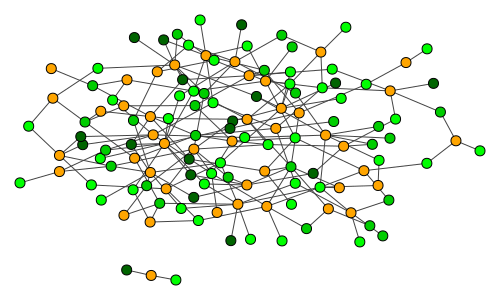

In [3]:
g=igraph.Graph.Bipartite([False]*nusers+[True]*nprods,[(i.User,i.Product) for i in data.itertuples()])
g.vs['color']=[3]*nusers+list(prod_cat)
g.delete_vertices([i for i in g.vs if g.degree(i)==0])
igraph.plot(g, vertex_color=[['green','green3','darkgreen','orange'][v['color']] for v in g.vs], bbox=(0,0,500,300),vertex_size=10)

Now plotting graphs of observed users with products in common – splitting them into balanced sets is not as easy as finding connected components or clustering the graph:

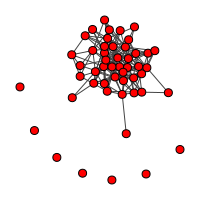

In [4]:
g=igraph.Graph(directed=False)
g.add_vertices(users)
g.add_edges([(i.User1,i.User2) for i in uel.itertuples()])
igraph.plot(g,bbox=(0, 0, 200, 200),vertex_size=8)

The cases in this random sample didn’t encompass all users or all products, and since there is no data for them, I’ll remove them and reindex their IDs:

In [5]:
# reassigning IDs of users and products
user_old_to_new=dict()
user_new_to_old=dict()
prod_old_to_new=dict()
prod_new_to_old=dict()

users_sampled=list(set(list(data.User)))
products_sampled=list(set(list(data.Product)))
users_sampled.sort()
products_sampled.sort()

cnt=0
for u in users_sampled:
    user_old_to_new[u]=cnt
    user_new_to_old[cnt]=u
    cnt+=1
cnt=0
for p in products_sampled:
    prod_old_to_new[p]=cnt
    prod_new_to_old[cnt]=p
    cnt+=1
    
# remapping original test data
data['User']=data.User.map(lambda u: int(user_old_to_new[u]))
data['Product']=data.Product.map(lambda p: int(prod_old_to_new[p]))
prod_cat=[prod_cat[p-nusers] for p in products_sampled]

nusers=len(users_sampled)
nprods=len(products_sampled)
users=[user_old_to_new[u] for u in users_sampled]
prods=[prod_old_to_new[p] for p in products_sampled]

Calculating some useful numbers and sets for later:

In [6]:
# tests per product
cases_per_prod=data.groupby('Product').size().to_dict()
obs_per_prod=[cases_per_prod[p] for p in range(nprods)]

# tests per user
cases_per_user=data.groupby('User').size().to_dict()
obs_per_user=[cases_per_user[u] for u in range(nusers)]

# dct which users tested which products
prods_per_user=dict()
for user,df in data.groupby('User'):
    prods_per_user[user]=set(list(df.Product))

# dct which products were tested by each user
users_per_prod=dict()
for product,df in data.groupby('Product'):
    users_per_prod[product]=set(list(df.User))
    
# split sets: train=0,test=1
sets=[0,1]

<a id="p2"></a>
## 2. Modeling the problem - Non-intersecting sets

<a id="p21"></a>
### 2.1 Mathematical Formulation


The splitting problem can be expressed into finding binary (i.e. 0/1 values) variables that satisfy the following mathematical problem:
<center>('u' denotes users, 'p' denotes products and 's' denotes the set (train-test))</center>

$$ max \: \sum_{u,p,s} Observation_{u,p,s} $$
<center>(maximize the number of observations assigned to either set)</center>
$$ $$
$$ s.t. $$
$$ $$
$$ \left\vert Observations \,from\, user\, u \right\vert \times User_{u,s} \ge \sum_p Observation_{u,p,s} \:\forall\, u,s  $$ <center>(Users belong to a set if there is at least one observation from them on it)</center>
$$   $$
$$ \left\vert Observations\, from \,product\, p \right\vert \times Product_{p,s} \ge \sum_u Observation_{u,p,s} \:\forall\, p,s  $$ <center>(Products belong to a set if there is at least one observation from them on it)</center>
$$ $$
$$ \sum_s User_{u,s} \le 1 \:\forall\,u $$ <center>(each user belongs to at most 1 set)</center>
$$ $$
$$ \sum_s Product_{p,s} \le 1 \:\forall\,p $$ <center>(each product belongs to at most 1 set)</center>
$$ $$
$$ \sum_{p \, \in \, category} \sum_{u} Observation_{u,p,s} \ge \left\vert Minimum\, Category\, Sample \right\vert \:\forall\, 
s,categories$$<center>(There is a minimum number of products from each category in each set)</center>
$$ $$
$$ \sum_{u,s} User_{u,s} \ge \left\vert Minimum \, User \, Sample \, \right\vert \:\forall \, u,s  $$<center>(There is a minimum number of users in each set)</center>
$$ $$
$$ \sum_{u,p} Observation_{u,p,s} \ge \left\vert\ Minimum \, Set \, Size \right\vert \:\forall\, s  $$<center>(There is a minimum number of observations in each set)</center>
$$ $$
$$ \sum_{s=train} Observation_{u,p,s} - 1.5 \sum_{s=test} Observation_{u,p,s} \ge 0 $$<center>(The training set contains at least one and a half times more observations than the test set)</center>
$$ $$
$$  Observation_{u,p,s}, User_{u,s}, Product_{p,s} \in \{ 0,1 \}  $$<center>(All decision variables are binary)</center>

<a id="p22"></a>
### 2.2 Modeling the problem in or-tools

Creating the necessary decision variables

In [7]:
from ortools.linear_solver import pywraplp

# starting solver
solver = pywraplp.Solver('split',pywraplp.Solver.CBC_MIXED_INTEGER_PROGRAMMING)

# variables indicating to which set does each user belong
user=[[solver.BoolVar("User"+str(u)+"Split"+str(s)) for s in sets] for u in range(nusers)]

# variables indicating to which set does each product belong
product=[[solver.BoolVar("Product"+str(p)+"Split"+str(s)) for s in sets] for p in range(nprods)]

# variables indicating to which split does each observation belong
obs=[[[None for s in sets] for p in prods] for u in users]
for i in data.itertuples():
    for s in sets:
        varname="Group"+str(s)+"User"+str(int(i.User))+"Product"+str(int(i.Product))
        obs[int(i.User)][int(i.Product)][s]=solver.BoolVar(varname)

Now the optimization objective and constraints:

In [8]:
# maximize assigned cases
solver.Maximize(solver.Sum(obs[i.User][i.Product][s] for i in data.itertuples() for s in sets))

# users assgined to a set
for u in range(nusers):
    for s in sets:
        solver.Add(obs_per_user[u]*user[u][s] >= solver.Sum(obs[u][p][s] for p in prods_per_user[u]))
    
# products assigned to a set
for p in range(nprods):
    for s in sets:
        solver.Add(obs_per_prod[p]*product[p][s] >= solver.Sum(obs[u][p][s] for u in users_per_prod[p]))

# no same user in different sets
for u in range(nusers):
    solver.Add(user[u][0] + user[u][1] <= 1)

# no same product in different sets
for p in range(nprods):
    solver.Add(product[p][0] + product[p][1] <= 1)

# minimum size for each set
u_train=10
u_test=10
c_train=50
c_test=50
p_cat=5
solver.Add(solver.Sum(user[u][0] for u in range(nusers))>=u_train)
solver.Add(solver.Sum(user[u][1] for u in range(nusers))>=u_test)
solver.Add(solver.Sum(obs[i.User][i.Product][0] for i in data.itertuples())>=c_train)
solver.Add(solver.Sum(obs[i.User][i.Product][1] for i in data.itertuples())>=c_test)

for c in range(ncategs):
    solver.Add(solver.Sum(obs[i.User][i.Product][0] for i in data.itertuples() if (prod_cat[i.Product]==c))>=p_cat)
    solver.Add(solver.Sum(obs[i.User][i.Product][1] for i in data.itertuples() if (prod_cat[i.Product]==c))>=p_cat)

# balanced split
solver.Add(solver.Sum(obs[i.User][i.Product][0]-1.5*obs[i.User][i.Product][1] for i in data.itertuples())>=0)

<ortools.linear_solver.pywraplp.Constraint; proxy of <Swig Object of type 'operations_research::MPConstraint *' at 0x00000000042E30F0> >

Now letting CBC solve it - a result code of zero means an optimal solution was found, whereas 2 means it failed

In [9]:
# solve
solver.Solve()

0

<a id="p23"></a>
### 2.3 Examining the results

Extracting the results (not the most efficient way of doing it, but the small number of variables allows for it):

In [10]:
import re

user_arr=dict()
prod_arr=dict()
r1="^User([0-9]+)Split([0-9])"
r2="^Product([0-9]+)Split([0-9])"


for u in user:
    s1=u[0].solution_value()>.5
    s2=u[1].solution_value()>.5
    u=int(re.match(r1,u[0].name()).groups()[0])
    if s1 and s2:
        user_arr[u]=-1
    elif s1:
        user_arr[u]=0
    elif s2:
        user_arr[u]=1
        
for p in product:
    s1=p[0].solution_value()>.5
    s2=p[1].solution_value()>.5
    u=int(re.match(r2,p[0].name()).groups()[0])
    if s1 and s2:
        prod_arr[u]=-1
    elif s1:
        prod_arr[u]=0
    elif s2:
        prod_arr[u]=1
        
user_arr=pd.DataFrame([(k,v) for k,v in user_arr.items()],columns=['User','Group'])
prod_arr=pd.DataFrame([(k,v) for k,v in prod_arr.items()],columns=['Product','Group'])

Now examining the split that CBC found:

In [11]:
users_train=set(list(user_arr.User[user_arr.Group==0]))
users_test=set(list(user_arr.User[user_arr.Group==1]))
prods_train=set(list(prod_arr.Product[prod_arr.Group==0]))
prods_test=set(list(prod_arr.Product[prod_arr.Group==1]))

cases_train=len([i for i in data.itertuples() if (i.User in users_train) and (i.Product in prods_train)])
cases_test=len([i for i in data.itertuples() if (i.User in users_test) and (i.Product in prods_test)])
print('Total observations in train set:',cases_train)
print('Total observations in test set:',cases_test)
print('Proportion of cases assigned to either set:','{:.2%}'.format((cases_train+cases_test)/data.shape[0]))
print()
print('Users in train set:',len(users_train))
print('Users in test set:',len(users_test))
print('Products in train set:',len(prods_train))
print('Products in test set:',len(prods_test))

Total observations in train set: 129
Total observations in test set: 50
Proportion of cases assigned to either set: 89.95%

Users in train set: 29
Users in test set: 15
Products in train set: 58
Products in test set: 29


<a id="p3"></a>
## 3. Alternative model - Soft-assignment, cliques and larger dataset

The model used before does the job, but it scales poorly with problem size and might not be the most efficient way of obtaining such a split.

If we lower the standards, the problem can also be modeled with a soft assignment of users and products to sets – that is, allowing them to be in either set, but minimizing  the number of repeated cases (users and products that belong to both sets). As such, it's also possible to (efficently) define the maximum and minimum proportion of the data that one of the sets should be assigned (e.g. test set being between 20% and 40% of the data).

In addition, it’s also possible to use information from a (mathematical) graph of users connected by products (each user is a node and there is an edge between two users whenever there is feedback for a product in common), and of products connected by users, by finding cliques of such graphs (subsets of nodes that are all connected to each other).

If we are to include all observations in each set, then whenever two users have a product in common, those users should belong to the same set, and whenever two products have a user in common, those products should belong to the same set. The same logic can be extended to larger numbers of users/products connected by products/users – these are obtained by the cliques of such graphs.

If there existed such a split that would include all observations while assigning totally different users and products to each set (such a split didn’t exist in the simulation before), then the problem would be simple: if a user/product belongs in a clique, then all users/products in the clique belong to the same set, and no user/product in the clique belongs to the other set. Such a model would work by adding an extra variable indicating to which set does the clique belong, and inequalities like this: 

$$ \sum_{u \in clique} User_{u,s=train} = \left\vert Clique \, Cardinality \right\vert \times W_{clique} \: \forall\, user\, clique  $$
$$ \sum_{u \in clique} User_{u,s=test} = \left\vert Clique \, Cardinality \right\vert \times (1-W_{clique}) \: \forall\, user\, clique  $$
$$ W_{clique} \in \{0,1\} \:\forall\, user\,clique  $$
$$ $$
<center>And similarly for product cliques:</center>
$$ $$
$$ \sum_{p \in clique} Product_{p,s=train} = \left\vert Clique \, Cardinality \right\vert \times W_{clique} \: \forall\, product\, clique  $$
$$ \sum_{p \in clique} Product_{p,s=test} = \left\vert Clique \, Cardinality \right\vert \times (1-W_{clique}) \: \forall\, product\, clique  $$
$$ W_{clique} \in \{0,1\} \:\forall\, product\,clique  $$

In this case, however, since users and products can be in both sets, these two inequalities will likely not hold. If we know beforehand to which set does a clique belong, then it would be possible to change one of those equalities to an inequality (if w=1 means the clique is in the training set, then $\le$ for the first one and $\ge$ for the second one). 

Since finding all cliques of a graph is a very algorithmically complex operation, and adding too many constraints can slowdown the linear solver, it’s possible to work with this by finding only the maximal cliques of a graph (for which there are more efficient algorithms), and as the training data is supposed to be larger, we can assume (albeit perhaps incorrectly) that the largest cliques would end up in the training data. Note that the solution might not be exactly the same as without the cliques constraints – it might even make the solver fail as it would discard some otherwise valid solutions – but it can speed up things enormously.

<a id="p31"></a>
### 3.1 Mathematical formulation

Alltogether, such a problem formulation would now look like this:

$$ min \: \sum_s(\sum_u User_{u,s} + \sum_p Product_{p,s}) $$
$$ $$
$$ s.t. $$
$$ $$
<center>Users and products belong to at least one set</center>
$$ \sum_s User_{u,s} \ge 1 \:\forall\, u $$
$$ \sum_s Product_{p,s} \ge 1 \:\forall\, p  $$
$$ $$
<center>If an observation from them is in a set, they have to be in that set</center>
$$ \left\vert Observations\,from\,user\,u \right\vert \times User_{u,s=train} \ge \sum_p Observation_{u,p} \:\forall\, u $$
$$ \left\vert Observations\,from\,user\,u \right\vert \times User_{u,s=test} \ge \left\vert Observations\,from\,user\,u \right\vert - \sum_p Observation_{u,p} \:\forall\, u  $$
$$ $$
$$ \left\vert Observations\,from\,product\,p \right\vert \times Product_{p,s=train} \ge \sum_u Observation_{u,p} \:\forall\, p  $$
$$ \left\vert Observations\,from\,product\,p \right\vert \times Product_{p,s=test} \ge \left\vert Observations\,from\,product\,p \right\vert - \sum_u Observation_{u,p} \:\forall\, p  $$

$$ $$
<center>Sets have to include a minimum of samples of users and product categories, and be balanced</center>
$$ \sum_{p \in category,s} Product_{p,s} \ge \left\vert Minimum\, Category\, Sample \right\vert \:\forall\, 
s,categories    $$
$$ \sum_u User_{u,s} \ge \left\vert Minimum\, User\, Sample \right\vert \:\forall\, 
s  $$
$$ \sum_{u,p} Observation_{u,p} - MinPercTest\times TotalObs \ge 0  $$
$$ \sum_{u,p} Observation_{u,p} - (1-MaxTestPerc)\times TotalObs \le 0$$
$$   $$
$$ $$
<center>Adding the clique constraints</center>
$$ \sum_{u \in clique} User_{u,s=train} = \left\vert Clique \, Cardinality \right\vert \times W_{clique} \: \forall\, maximal \,user\, clique  $$
$$ \sum_{u \in clique} User_{u,s=test} \ge \left\vert Clique \, Cardinality \right\vert \times (1-W_{clique}) \: \forall\,maximal\, user\, clique  $$

$$ $$
$$ \sum_{p \in clique} Product_{p,s=train} = \left\vert Clique \, Cardinality \right\vert \times W_{clique} \: \forall\, maximal \, product\, clique  $$
$$ \sum_{p \in clique} Product_{p,s=test} \ge \left\vert Clique \, Cardinality \right\vert \times (1-W_{clique}) \: \forall\, maximal \, product\, clique  $$

$$ $$
<center>All decision variables are binary</center>
$$ Observation_{u,p}, User_{u,s}, Product_{p,s}, W_{clique} \in \{0,1\} \:\forall\, u,p,s,maximal\,user\,and\,product\,clique $$

_Note that now there is only one binary variable per observation, rather than one per observation belonging to each set, as this time they all belong to either set. If an observation variable equals 1, then that observation belongs to the test set, if it euqals zero, it belongs to the training set._

<a id="p32"></a>
### 3.2 Simulating a larger dataset

Generating a bigger dataset - same way as before, but this time with:
* 100 users
* 200 products
* 5 product categories
* 400 samples

In [12]:
nusers=100
nprods=200
ncategs=5
users=[u for u in range(nusers)]
prods=[p for p in range(nprods)]
np.random.seed(1)
prod_cat=np.random.choice([0,1,2,3,4],p=[.4,.2,.2,.1,.1],size=nprods)
user_prob=np.random.beta(a=3,b=3,size=nusers)
item_prob=np.random.beta(a=4,b=3,size=nprods)

user_prob=user_prob/np.sum(user_prob)
item_prob=item_prob/np.sum(item_prob)
data=list()
for i in range(400):
    data.append((np.random.choice(users,p=user_prob),np.random.choice(prods,p=item_prob)))
    
data=pd.DataFrame(data,columns=['User','Product']).drop_duplicates()
# reassigning IDs of users and products
user_old_to_new=dict()
user_new_to_old=dict()
prod_old_to_new=dict()
prod_new_to_old=dict()

users_sampled=list(set(list(data.User)))
products_sampled=list(set(list(data.Product)))
users_sampled.sort()
products_sampled.sort()

cnt=0
for u in users_sampled:
    user_old_to_new[u]=cnt
    user_new_to_old[cnt]=u
    cnt+=1
cnt=0
for p in products_sampled:
    prod_old_to_new[p]=cnt
    prod_new_to_old[cnt]=p
    cnt+=1
    
# remapping original test data
data['User']=data.User.map(lambda u: int(user_old_to_new[u]))
data['Product']=data.Product.map(lambda p: int(prod_old_to_new[p]))

nusers=len(users_sampled)
nprods=len(products_sampled)
prod_cat=[prod_cat[p] for p in products_sampled]
users=[user_old_to_new[u] for u in users_sampled]
prods=[prod_old_to_new[p] for p in products_sampled]

In [13]:
# tests per product
cases_per_prod=data.groupby('Product').size().to_dict()
obs_per_prod=[cases_per_prod[p] for p in range(nprods)]

# tests per user
cases_per_user=data.groupby('User').size().to_dict()
obs_per_user=[cases_per_user[u] for u in range(nusers)]

# dct which users tested which products
prods_per_user=dict()
for user,df in data.groupby('User'):
    prods_per_user[user]=set(list(df.Product))

# dct which products were tested by each user
users_per_prod=dict()
for product,df in data.groupby('Product'):
    users_per_prod[product]=set(list(df.User))
    
# split sets: train=0,test=1
sets=[0,1]

<a id="p33"></a>
### 3.3 Obtaining the maximal cliques

Maximal cliques can be obtained efficiently with either igraph or or-tools – here I’ll use igraph:

In [14]:
# constructing graph of users who tested the same products
g_users=igraph.Graph()
g_users.add_vertices(nusers)

left_side=data.copy()
right_side=data.copy()
left_side.rename(columns={"User":"User1"},inplace=True)
right_side.rename(columns={"User":"User2"},inplace=True)
edges=pd.merge(left_side,right_side,on="Product")
edges=edges.loc[edges.User1<edges.User2][['User1','User2']].drop_duplicates()
g_users.add_edges([(i.User1,i.User2) for i in edges.itertuples()])

# constructing graph of products tested by the same users
g_products=igraph.Graph()
g_products.add_vertices(nprods)
left_side.rename(columns={"User1":"User","Product":"Product1"},inplace=True)
right_side.rename(columns={"User2":"User","Product":"Product2"},inplace=True)
edges=pd.merge(left_side,right_side,on="User")
edges=edges.loc[edges.Product1<edges.Product2][['Product1','Product2']].drop_duplicates()
g_products.add_edges([(i.Product1,i.Product2) for i in edges.itertuples()])

#finding cliques for both
c_users=g_users.largest_cliques()
c_products=g_products.largest_cliques()

<a id="p34"></a>
### 3.4 Modeling the problem in or-tools

Creating the decision variables

In [15]:
# starting solver
solver = pywraplp.Solver('split',pywraplp.Solver.CBC_MIXED_INTEGER_PROGRAMMING)

# variables indicating to which set does each user belong
user=[[solver.BoolVar("User"+str(u)+"Split"+str(s)) for s in sets] for u in range(nusers)]

# variables indicating to which set does each product belong
product=[[solver.BoolVar("Product"+str(p)+"Split"+str(s)) for s in sets] for p in range(nprods)]

# variables indicating to which split does each test case belong
obs=[[None for p in prods] for u in users]
for i in data.itertuples():
    varname="User"+str(int(i.User))+"Product"+str(int(i.Product))
    obs[int(i.User)][int(i.Product)]=solver.BoolVar(varname)

Now modeling the problem:

In [16]:
import math

# minimize repeated users and products
solver.Minimize(solver.Sum(user[u][s] for u in range(nusers) for s in sets)+solver.Sum(product[p][s] for p in range(nprods) for s in sets))


# each user and product belongs to at least one set
solver.Add(solver.Sum(user[u][0]+user[u][1] for u in range(nusers))>=1)
solver.Add(solver.Sum(product[p][0]+product[p][1] for p in range(nprods))>=1)

# users assgined to a set
for u in range(nusers):
    solver.Add(obs_per_user[u]*user[u][0] >= solver.Sum(obs[u][p] for p in prods_per_user[u]))
    solver.Add(obs_per_user[u]*user[u][1] >= obs_per_user[u]-solver.Sum(obs[u][p] for p in prods_per_user[u]))
    
# products assigned to a set
for p in range(nprods):
    solver.Add(obs_per_prod[p]*product[p][0] >= solver.Sum(obs[u][p] for u in users_per_prod[p]))
    solver.Add(obs_per_prod[p]*product[p][1] >= obs_per_prod[p]-solver.Sum(obs[u][p] for u in users_per_prod[p]))
    
# balanced split
min_perc_test=0.2
max_perc_test=0.4
solver.Add(solver.Sum(obs[i.User][i.Product] for i in data.itertuples())-math.floor((1-max_perc_test)*data.shape[0])<=0)
solver.Add(solver.Sum(obs[i.User][i.Product] for i in data.itertuples())-math.ceil(min_perc_test*data.shape[0])>=0)

# minimum size for each set
min_users_train=25
min_users_test=25
solver.Add(solver.Sum(user[u][0] for u in range(len(users)))>=min_users_train)
solver.Add(solver.Sum(user[u][1] for u in range(len(users)))>=min_users_test)

min_prods_per_cat=5
for c in range(ncategs):
    solver.Add(solver.Sum(product[p][0] for p in range(nprods) if prod_cat[p]==c)>=min_prods_per_cat)
    solver.Add(solver.Sum(product[p][1] for p in range(nprods) if prod_cat[p]==c)>=min_prods_per_cat)

# adding cliques of users
w_cliques_users=[solver.BoolVar("W_UserClique"+str(cl)) for cl in range(len(c_users))]
for cl in range(len(c_users)):
    C=len(c_users[cl])
    solver.Add(solver.Sum(user[u][0] for u in c_users[cl])==w_cliques_users[cl]*C)
    solver.Add(solver.Sum(user[u][1] for u in c_users[cl])>=(1-w_cliques_users[cl])*C)
    
#adding cliques for products
w_cliques_products=[solver.BoolVar("W_ProductClique"+str(cl)) for cl in range(len(c_products))]
for cl in range(len(c_products)):
    C=len(c_products[cl])
    solver.Add(solver.Sum(product[p][0] for p in c_products[cl])==w_cliques_products[cl]*C)
    solver.Add(solver.Sum(product[p][1] for p in c_products[cl])>=(1-w_cliques_products[cl])*C)


Solving:

In [17]:
solver.Solve()

0

<a id="p35"></a>
### 3.5 Examining the results

In [18]:
# extract results
import re
res_arr=dict()
r0="^User([0-9]+)Product([0-9]+)$"

for u in obs:
    for p in u:
        if not (p is None):
            us,pr=re.match(r0,p.name()).groups()
            us=int(us)
            pr=int(pr)
            res_arr[(us,pr)]=p.solution_value()
            
res_arr=pd.DataFrame([(k[0],k[1],v) for k,v, in res_arr.items()],columns=['User','Product','Group'])

users_train=set(list(res_arr.loc[res_arr.Group==0]['User']))
users_test=set(list(res_arr.loc[res_arr.Group==1]['User']))
prods_train=set(list(res_arr.loc[res_arr.Group==0]['Product']))
prods_test=set(list(res_arr.loc[res_arr.Group==1]['Product']))

users_unique_train=users_train.difference(users_test)
users_unique_test=users_test.difference(users_train)
prods_unique_train=prods_train.difference(prods_test)
prods_unique_test=prods_test.difference(prods_train)
cases_unique_train=data.loc[(data.User.map(lambda x: x in users_unique_train))&(data.Product.map(lambda x: x in prods_unique_train))]
cases_unique_test=data.loc[(data.User.map(lambda x: x in users_unique_test))&(data.Product.map(lambda x: x in prods_unique_test))]


print('Proportion of observations in training data:','{:.2%}'.format(res_arr.loc[res_arr.Group==0].shape[0]/data.shape[0]))
print('Proportion of observations in test data:','{:.2%}'.format(res_arr.loc[res_arr.Group==1].shape[0]/data.shape[0]))
print()
print('Proportion of users belonging exclusively to train data','{:.2%}'.format(len(users_unique_train)/nusers))
print('Proportion of users belonging exclusively to test data','{:.2%}'.format(len(users_unique_test)/nusers))
print('Proportion of products belonging exclusively to train data','{:.2%}'.format(len(prods_unique_train)/nprods))
print('Proportion of products belonging exclusively to test data','{:.2%}'.format(len(prods_unique_test)/nprods))

Proportion of observations in training data: 79.69%
Proportion of observations in test data: 20.31%

Proportion of users belonging exclusively to train data 65.93%
Proportion of users belonging exclusively to test data 14.29%
Proportion of products belonging exclusively to train data 75.61%
Proportion of products belonging exclusively to test data 23.78%


The split seems good - now the data is ready for the next phase: building and evaluating recommendation algorithms!